# A prototype for automatic clinical image segmentation
### Georges Tod, April 2020

In [1]:
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.segmentation import chan_vese

import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray

from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image

import time
import numpy as np
from numpy import linalg as LA

from sklearn.svm import SVC
from sklearn.externals import joblib


/home/jupyter/anaconda3/envs/imageLab/lib/python3.8/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Auxiliary functions

In [2]:
def find_weights(centered_vector,m,n,vS):
    w = np.dot(centered_vector[m,:],vS[:,:n])
    return w

def comp_image(w,n,vS,mean):
    rec = np.dot(w,(vS.T)[:n,:])+mean
    return rec


def correct_image_size(image,window_size):
    # will set it to a divideable window size
    
    i1 = len(image[:,0])
    i2 = len(image[0,:])
    newdim1 = (int(i1/window_size)+1)*window_size
    newdim2 = (int(i2/window_size)+1)*window_size
    
    rowS = np.zeros([newdim1-i1,i2])
    colS = np.zeros([newdim1,newdim2-i2])

    imR = np.concatenate((image,rowS))
    resized_image = np.concatenate((imR,colS),axis=1)

    return resized_image

def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, "{} rows is not evenly divisble by {}".format(h, nrows)
    assert w % ncols == 0, "{} cols is not evenly divisble by {}".format(w, ncols)
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

def unblockshaped(arr, h, w):
    """
    Return an array of shape (h, w) where
    h * w = arr.size

    If arr is of shape (n, nrows, ncols), n sublocks of shape (nrows, ncols),
    then the returned array preserves the "physical" layout of the sublocks.
    """
    n, nrows, ncols = arr.shape
    return (arr.reshape(h//nrows, -1, nrows, ncols)
               .swapaxes(1,2)
               .reshape(h, w))


def which_class(patch_num,threshold):
    s = sum(patches_SEGMENTED[patch_num].flatten())
    if s > threshold:
        return 1
    else:
        return 0
    
def im_dimensions(image):
    i1 = len(image[:,0])
    i2 = len(image[0,:])
    newdim1 = int(i1/window_size)
    newdim2 = int(i2/window_size)
    return [newdim1,newdim2]

# Training data

## raw data

(711, 445, 4) uint8


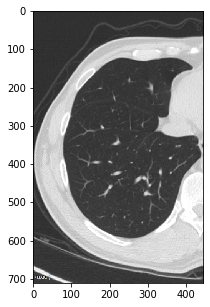

In [3]:
im = imread('example4_1.png')

print(im.shape, im.dtype)
plt.figure(figsize=(5,5))
plt.imshow(im, cmap=plt.cm.gray)
plt.show()

## to gray + zero padding for window size divisibility

In [4]:
window_size = 5

im_gray = rgb2gray(im)
im_gray = correct_image_size(im_gray,window_size)
im_gray.shape


(715, 450)

# Labelling training data: segmentation using a level-set method

10


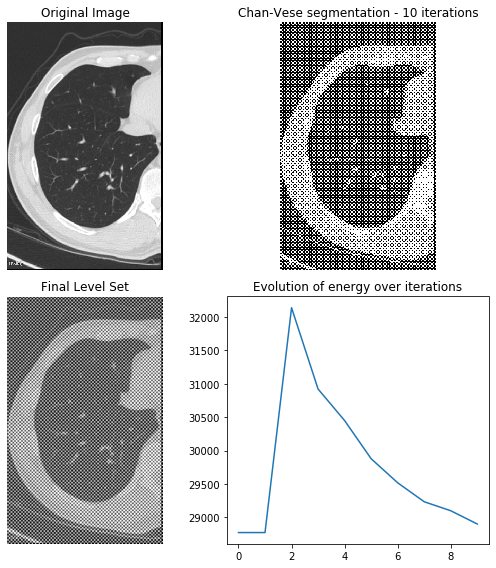

30


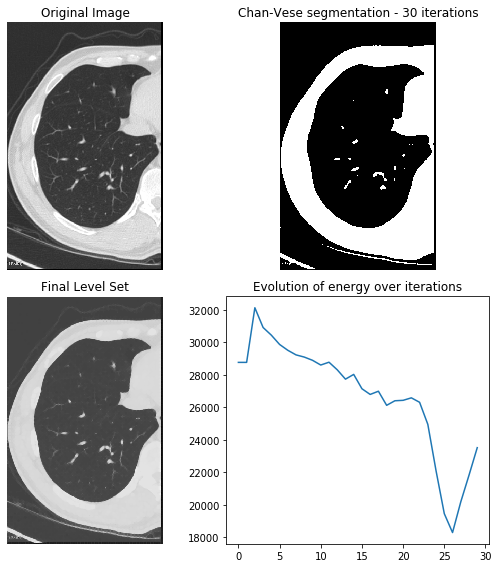

50


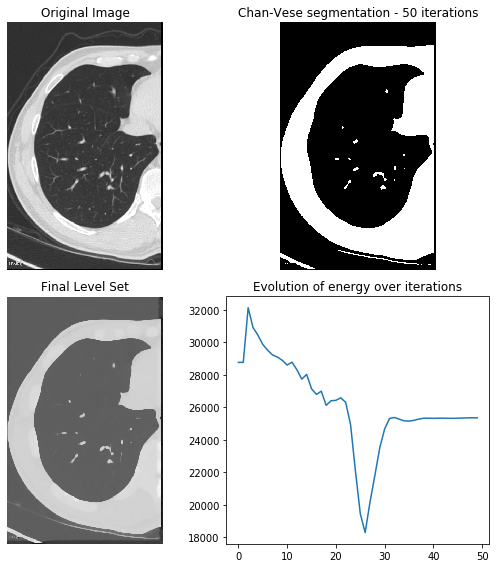

70


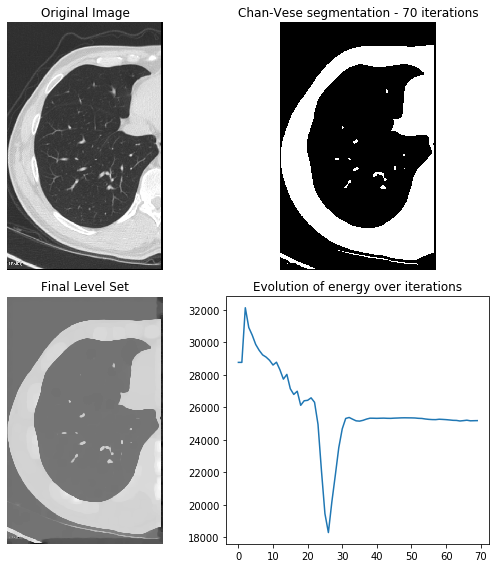

90


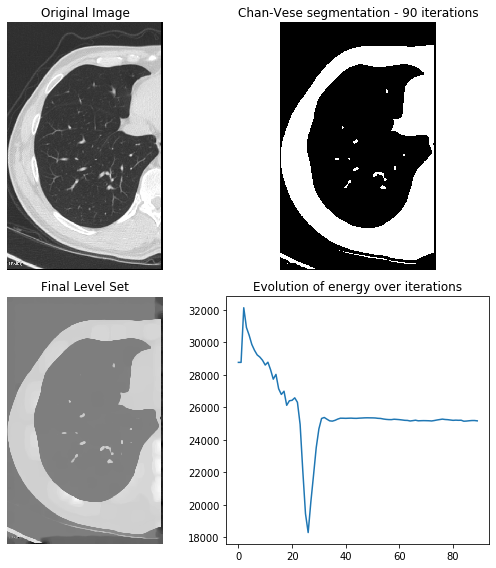

In [5]:
for i in range(10,100,20):
    print(i)
    
    cv = chan_vese(im_gray, mu=0.25, lambda1=1, lambda2=1, tol=1e-4, max_iter=i,
                   dt=0.5, init_level_set="checkerboard", extended_output=True)

    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    ax = axes.flatten()

    ax[0].imshow(im_gray, cmap="gray")
    ax[0].set_axis_off()
    ax[0].set_title("Original Image", fontsize=12)

    ax[1].imshow(cv[0], cmap="gray")
    ax[1].set_axis_off()
    title = "Chan-Vese segmentation - {} iterations".format(len(cv[2]))
    ax[1].set_title(title, fontsize=12)

    ax[2].imshow(cv[1], cmap="gray")
    ax[2].set_axis_off()
    ax[2].set_title("Final Level Set", fontsize=12)

    ax[3].plot(cv[2])
    ax[3].set_title("Evolution of energy over iterations", fontsize=12)

    fig.tight_layout()
    plt.show()

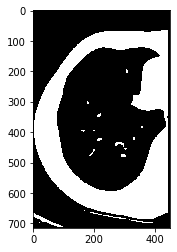

In [6]:
segmented_image = cv[0]
plt.imshow(segmented_image,cmap='gray')

# Window feature extraction

Patches shape: (12870, 5, 5)


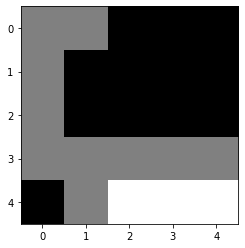

In [7]:
patches = blockshaped(im_gray,window_size,window_size)
print('Patches shape: {}'.format(patches.shape))
plt.imshow(patches[100,:],cmap='gray')

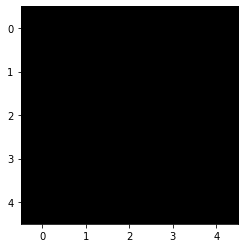

In [8]:
patches_SEGMENTED = blockshaped(segmented_image,window_size,window_size)
plt.imshow(patches_SEGMENTED[100,:],cmap='gray')

### collecting them and reshaping into a vector

In [9]:
sizeIM = len(patches[0].flatten())
tic = time.time()
bigM = []
for i in range(len(patches)):
    im = patches[i]
    imF = np.array(im).flatten()
    bigM.append(imF)

bigM = np.reshape(bigM,[len(patches),sizeIM])
elapsed = time.time()-tic
print(elapsed)

0.03306698799133301


## centering the patches

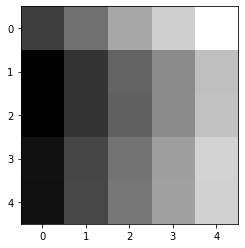

In [10]:
meanPATCH = bigM.mean(axis=0)
centered_patches = bigM - meanPATCH

plt.imshow(meanPATCH.reshape(window_size,window_size), cmap=plt.cm.gray)
plt.show()

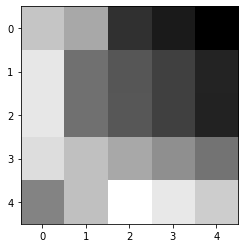

In [11]:
plt.imshow(centered_patches[100,:].reshape(window_size,window_size),cmap='gray')

# Feature dimension reduction using PCA

In [12]:
S = np.dot(centered_patches.T,centered_patches)
w,v = LA.eig(S)

In [13]:
indexS = np.argsort(w)[::-1]

wS = w[indexS]
vS = v[:,indexS]

In [14]:
np.save('vS',vS)

In [15]:
len(wS)

25

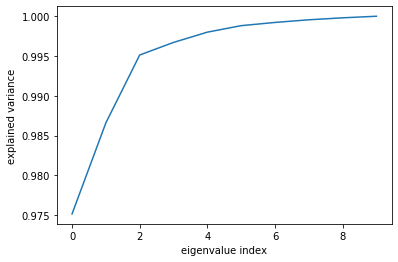

In [16]:
plt.plot(np.cumsum(wS[:10])/sum(wS[:10]))
plt.xlabel('eigenvalue index')
plt.ylabel('explained variance');

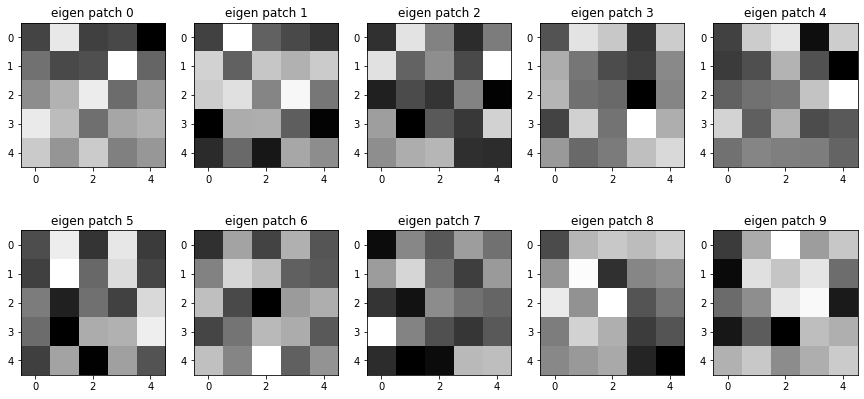

In [17]:
plt.figure(figsize=(15,7))
for i in range(10):
    
    plt.subplot(2,5,i+1)
    plt.imshow(vS[i].reshape(window_size,window_size), cmap=plt.cm.gray)
    plt.title('eigen patch ' + str(i))
    

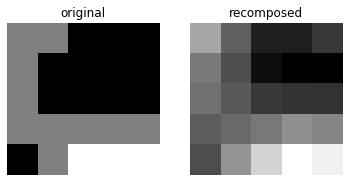

In [18]:
image_num = 100
n_vectors = 10

w = find_weights(centered_patches,image_num,n_vectors,vS)
rec = comp_image(w,n_vectors,vS,meanPATCH)

plt.figure
plt.subplot(1,2,1)
plt.imshow(patches[image_num,:].reshape(window_size,window_size), cmap=plt.cm.gray)
plt.axis('off')
plt.title("original")

plt.subplot(1,2,2)
plt.imshow(rec.reshape(window_size,window_size), cmap=plt.cm.gray)
plt.title("recomposed")

plt.axis('off')
plt.show()

In [19]:
bigM_compressed = []
class_patch = []
for i in range(len(patches)):
    w = find_weights(centered_patches,i,n_vectors,vS)    
    bigM_compressed.append(w)
    class_patch.append(which_class(i,10))
    

In [20]:
np.save('bigM_c',bigM_compressed)
np.save('class_patch',class_patch)

# SVM training

In [21]:
X = np.load('bigM_c.npy')
Y = np.load('class_patch.npy')

In [22]:
clf = SVC(gamma='auto')
clf.fit(X, Y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [23]:
filename = 'my_classifier.joblib.pkl'
_ = joblib.dump(clf, filename, compress=9)

# SVM validation

In [24]:
filename = 'my_classifier.joblib.pkl'
clf2 = joblib.load(filename)
clf2

#window_size = 20
#n_vectors = 10
vS = np.load('vS.npy')

(732, 444, 4) uint8
(735, 445) float64


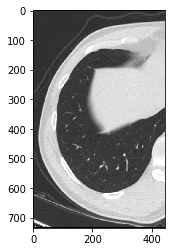

In [25]:
im = imread('example5_1.png')

print(im.shape, im.dtype)
imgray_val = rgb2gray(im)
imgray_val = correct_image_size(imgray_val,window_size)
print(imgray_val.shape, imgray_val.dtype)
plt.imshow(imgray_val, cmap=plt.cm.gray)
plt.show()

In [26]:
tic = time.time()

# patchwork
patches_val = blockshaped(imgray_val,window_size,window_size)
print('Patches shape: {}'.format(patches_val.shape))

sizeIM_val = len(patches_val[0].flatten())
bigM_val = []
for i in range(len(patches_val)):
    im = patches_val[i]
    imF = np.array(im).flatten()
    bigM_val.append(imF)

bigM_val = np.reshape(bigM_val,[len(patches_val),sizeIM_val])
elapsed = time.time()-tic
# centering
meanPATCH_val = bigM_val.mean(axis=0)
centered_patches_val = bigM_val - meanPATCH_val

bigM_compressed_val= []

# finding features
for i in range(len(patches_val)):
    w = find_weights(centered_patches_val,i,n_vectors,vS)    
    bigM_compressed_val.append(w)
    
# segmenting using trained SVM
Y_val = clf2.predict(bigM_compressed_val)
print(time.time()-tic)

# finding coordinates of class
Y_val_R = Y_val.reshape(im_dimensions(imgray_val))
countX = 0
coordX = []
coordY = []
for i in range(0,imgray_val.shape[0]-1,window_size):
    
    countY = 0
    for j in range(0,imgray_val.shape[1]-1,window_size):
        
        #print(i+10,j+10)
        if Y_val_R[countX,countY] == 1:
            coordX.append(j)
            coordY.append(i)
        countY +=1
    countX +=1

Patches shape: (13083, 5, 5)
0.14917922019958496


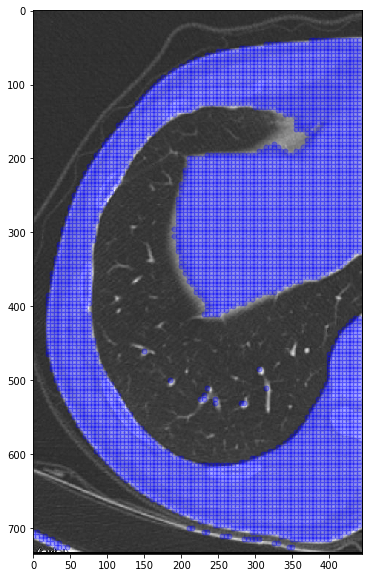

In [27]:
#plotting    
plt.figure(figsize=(10,10))
plt.imshow(imgray_val, cmap=plt.cm.gray)
for i in range(len(coordX)):
    plt.plot(coordX[i],coordY[i],'.b', markersize=10,alpha=.3)
    


### benchmark with Chan & Vese's level segmentation method

5.928202867507935


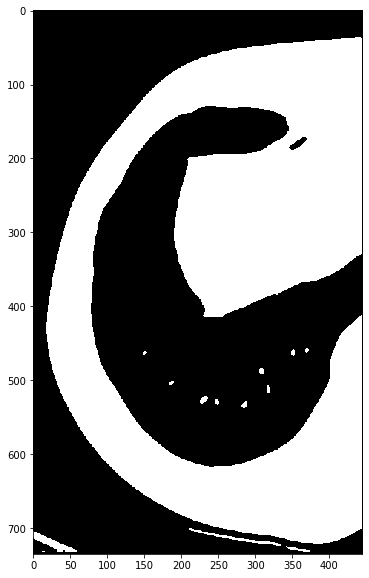

In [28]:
tic = time.time()
cv = chan_vese(imgray_val, mu=0.25, lambda1=1, lambda2=1, tol=1e-4, max_iter=100,
               dt=0.5, init_level_set="checkerboard", extended_output=True)

plt.figure(figsize=(10,10))
plt.imshow(cv[0], cmap=plt.cm.gray)

print(time.time()-tic)

## another image

(751, 455, 4) uint8
(755, 460) float64


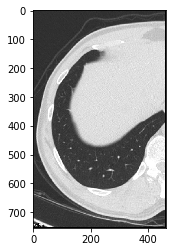

Patches shape: (13892, 5, 5)
0.1495347023010254
6.176179647445679


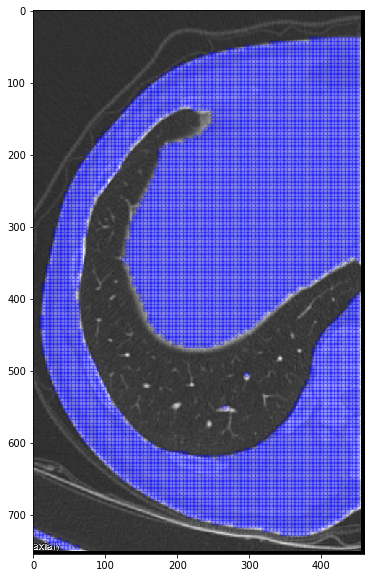

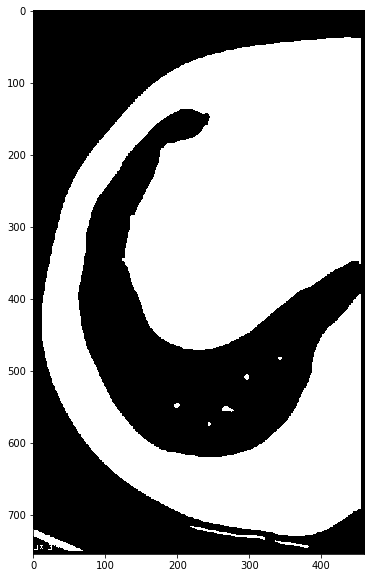

In [29]:
im = imread('example6_1.png')

print(im.shape, im.dtype)
imgray_val = rgb2gray(im)
imgray_val = correct_image_size(imgray_val,window_size)
print(imgray_val.shape, imgray_val.dtype)
plt.imshow(imgray_val, cmap=plt.cm.gray)
plt.show()

tic = time.time()

# patchwork
patches_val = blockshaped(imgray_val,window_size,window_size)
print('Patches shape: {}'.format(patches_val.shape))

sizeIM_val = len(patches_val[0].flatten())
bigM_val = []
for i in range(len(patches_val)):
    im = patches_val[i]
    imF = np.array(im).flatten()
    bigM_val.append(imF)

bigM_val = np.reshape(bigM_val,[len(patches_val),sizeIM_val])
elapsed = time.time()-tic
# centering
meanPATCH_val = bigM_val.mean(axis=0)
centered_patches_val = bigM_val - meanPATCH_val

bigM_compressed_val= []

# finding features
for i in range(len(patches_val)):
    w = find_weights(centered_patches_val,i,n_vectors,vS)    
    bigM_compressed_val.append(w)
    
# segmenting using trained SVM
Y_val = clf2.predict(bigM_compressed_val)
print(time.time()-tic)

# finding coordinates of class
Y_val_R = Y_val.reshape(im_dimensions(imgray_val))
countX = 0
coordX = []
coordY = []
for i in range(0,imgray_val.shape[0]-1,window_size):
    
    countY = 0
    for j in range(0,imgray_val.shape[1]-1,window_size):
        
        if Y_val_R[countX,countY] == 1:
            coordX.append(j)
            coordY.append(i)
        countY +=1
    countX +=1

#plotting    
plt.figure(figsize=(10,10))
plt.imshow(imgray_val, cmap=plt.cm.gray)
for i in range(len(coordX)):
    plt.plot(coordX[i],coordY[i],'.b', markersize=10,alpha=.3)
    

tic = time.time()
cv = chan_vese(imgray_val, mu=0.25, lambda1=1, lambda2=1, tol=1e-4, max_iter=100,
               dt=0.5, init_level_set="checkerboard", extended_output=True)

plt.figure(figsize=(10,10))
plt.imshow(cv[0], cmap=plt.cm.gray)

print(time.time()-tic)